# モンテカルロ法でCartPoleを学習する

In [1]:
# ref: http://neuro-educator.com/rl1/
# ref: https://qiita.com/sugulu/items/7a14117bbd3d926eb1f2

In [2]:
import gym
import numpy as np
import pandas as pd
from collections import deque 

import utils.display as disp
import utils.learning as learn

In [3]:
class LearningHistory:
    def __init__(self, max_size=200):
        self.buffer = deque(maxlen=max_size)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self):
        return self.buffer.pop()
    
    def len(self):
        return len(self.buffer)

class QMontecarlo:
    def __init__(self, num_state, num_action, alpha=0.5, gamma=0.99):
        #self.q_table = np.zeros(shape=(num_state, num_action))
        self.q_table = np.random.uniform(low=-1, high=1, size=(num_state, num_action))
        self.alpha = alpha # 学習率
        self.gamma = gamma# 時間割引率
    
    def get_action(self, state, episode):
         # ε-グリーディ法で行動を選択
        epsilon = 0.5 * (1 / (episode + 1))
        if epsilon <= np.random.uniform(0, 1):
            action = np.argmax(self.q_table[state])
        else:
            action = np.random.choice([0, 1])
        return action

    # 1エピソードの学習結果からQ値を更新する
    def update_q_table(self, history):
        total_reward_t = 0
        while (history.len() > 0):
            (state, action, reward) = history.sample()
            # 時間割引率をかける
            total_reward_t = self.gamma * total_reward_t
            # Q値 = 今回の報酬 + 未来に獲得できる報酬 に近づくように更新する
            q_value = self.q_table[state, action]
            self.q_table[state, action] = q_value+ self.alpha * (reward + total_reward_t - q_value)
            total_reward_t = total_reward_t + reward # ステップtより先に貰えた報酬

In [4]:
env = gym.make('CartPole-v0')
observation = env.reset()

observation_low = [-2.4, -3.0, -0.5, -2.0]
#observation_low = env.observation_space.low
observation_hight = [2.4, 3.0, 0.5, 2.0]
#observation_hight = env.observation_space.hight

num_max_episode = 5000 # 学習に使用するエピソード回数
num_max_step = 200 # 1エピソードのステップ数
num_action = 2 # アクション数
num_dizitized = 6 # observationを離散値にする際の分割数
num_state = num_dizitized ** observation.shape[0] # ステート数
num_goal_avg_episode = 10 # 学習を終了させる平均計算をするエピソード数
goal_avg_rewaed = 195 # 学習を終了させる平均報酬

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


## 訓練

In [5]:
learning = QMontecarlo(num_state, num_action)

history = LearningHistory(num_max_step)
rewards = []
rewards_goal_eval = np.zeros(num_goal_avg_episode)

for episode in range(num_max_episode):
    total_reward = 0
    observation = env.reset()
    state = learn.digitize_state(observation, observation_low, observation_hight, num_dizitized)
    action = learning.get_action(state, episode)
    
    for step in range(num_max_step):
        next_observation, reward, done, info =  env.step(action)
        if done:
            if step < 195:
                # 失敗
                reward = -200
            else:
                reward = 1
        else:
            reward = 1
            
        history.add((state, action, reward))
        next_state = learn.digitize_state(next_observation, observation_low, observation_hight, num_dizitized)
        next_action = learning.get_action(next_state, episode)
        total_reward += reward
        state = next_state
        action = next_action
        if done:
            learning.update_q_table(history)
            rewards.append(total_reward)
            rewards_goal_eval = np.hstack((rewards_goal_eval[1:], total_reward))
            break
            
    # ゴール達成のため学習終了
    reward_avg = rewards_goal_eval.mean()
    if episode % 100 == 0:
        print('episode: {}, episode_reward: {}'.format(episode, reward_avg))
    if reward_avg >= goal_avg_rewaed:
        print('learning finished: {}'.format(episode))
        break

episode: 0, episode_reward: -18.5
learning finished: 70


### 学習後のQ値でシュミレーション


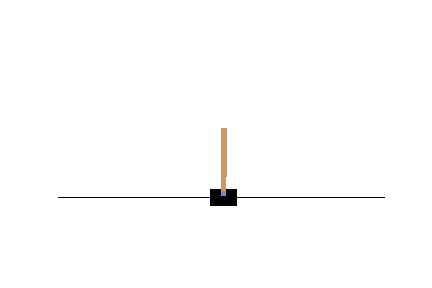
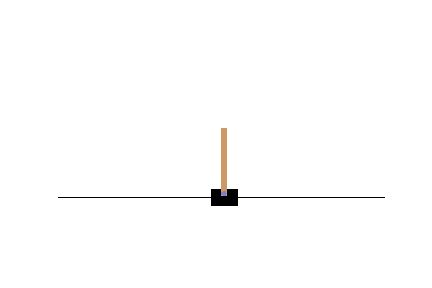
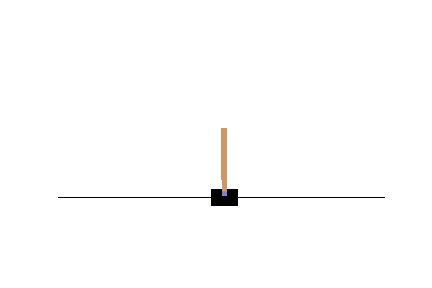
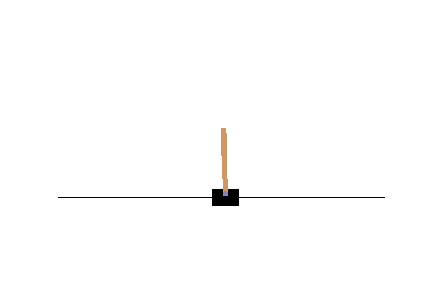
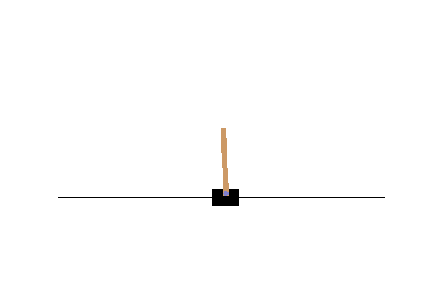
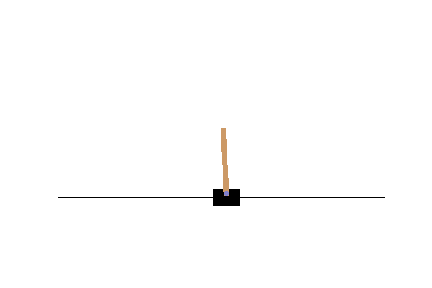
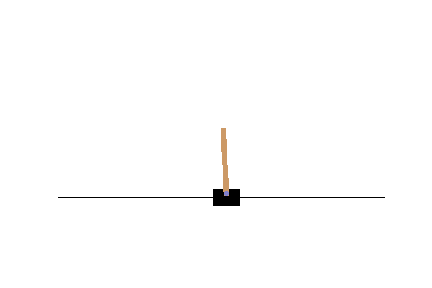
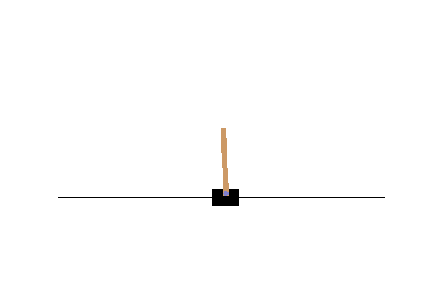
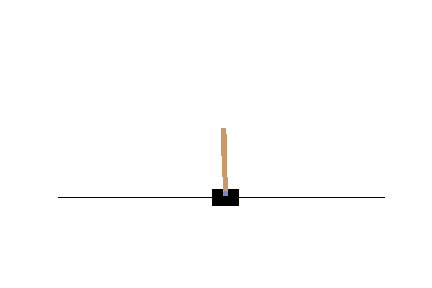
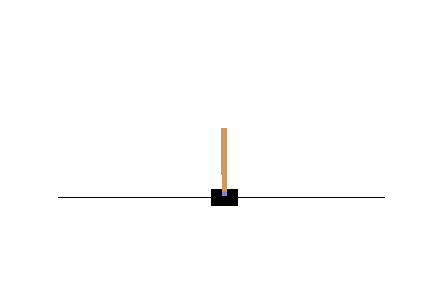
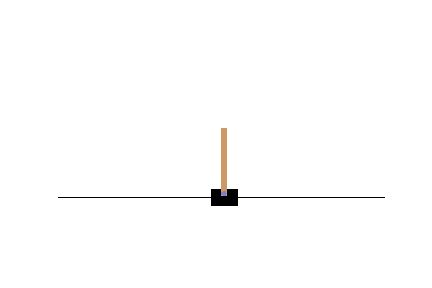
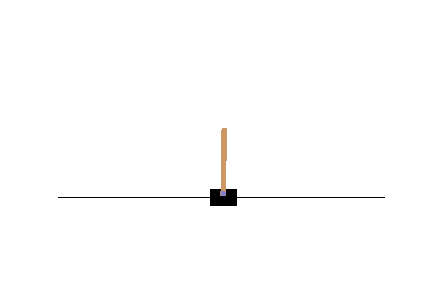
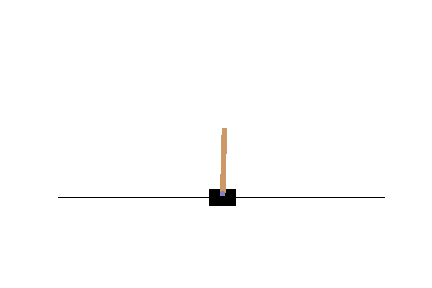
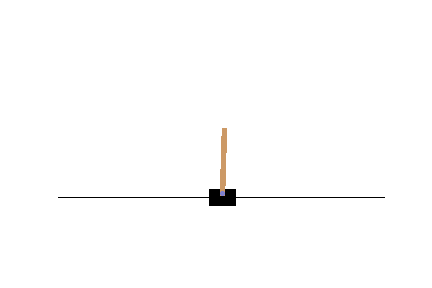
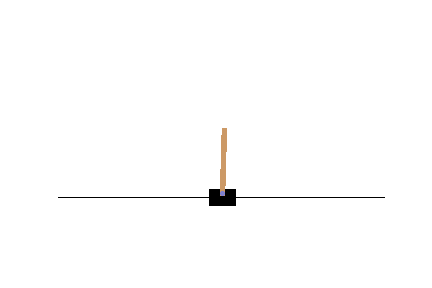
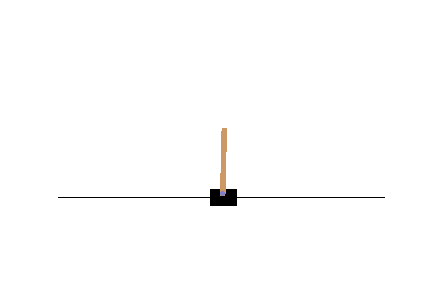
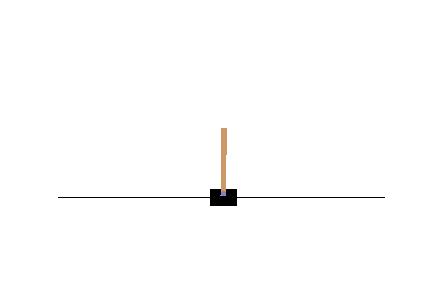
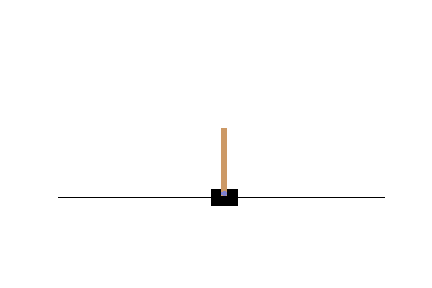
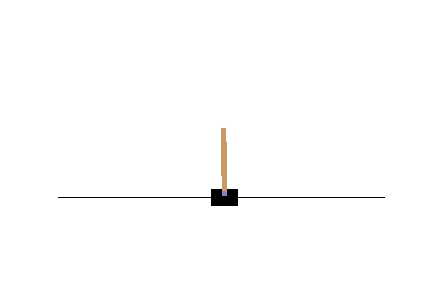
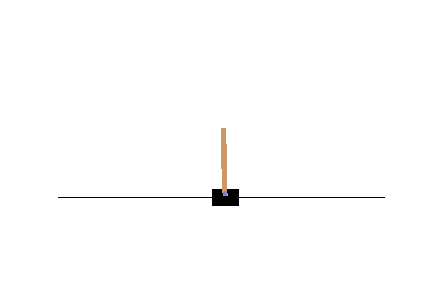
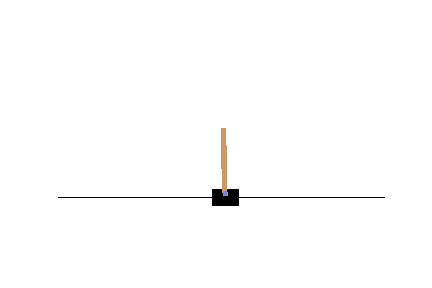
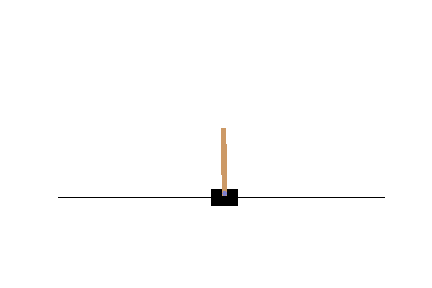
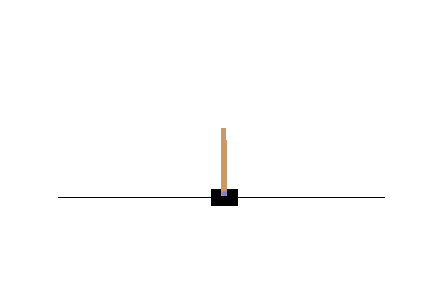
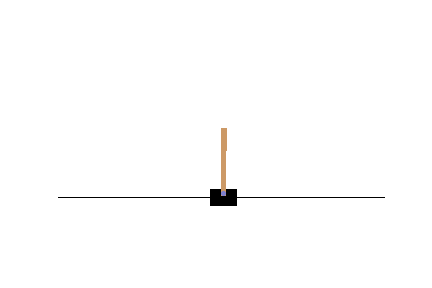
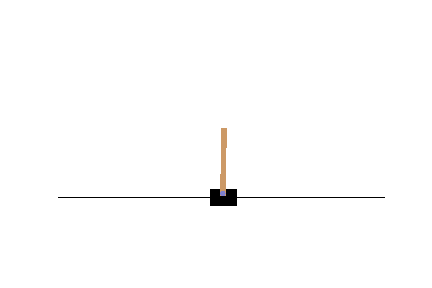
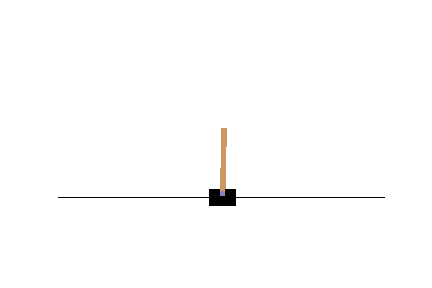
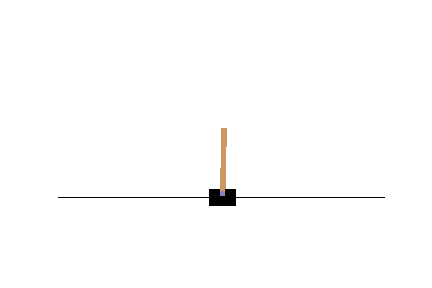
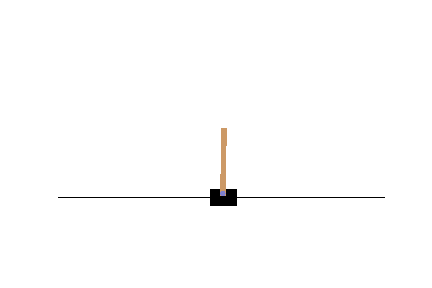
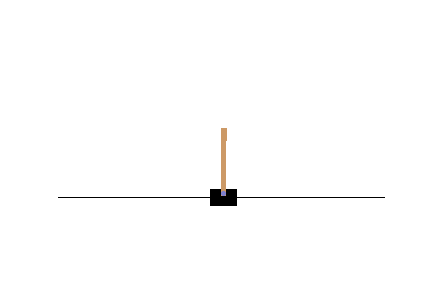
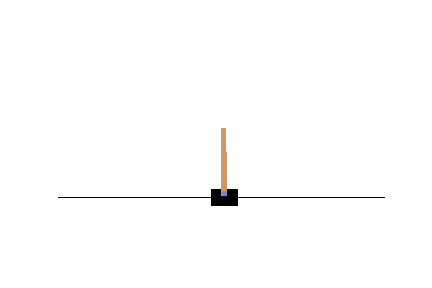
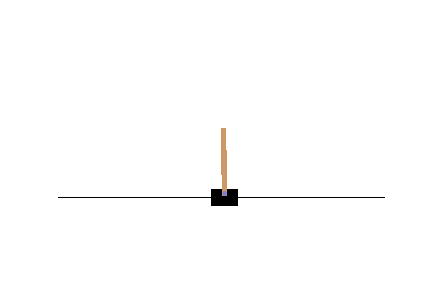
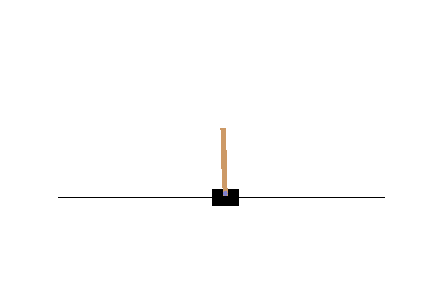
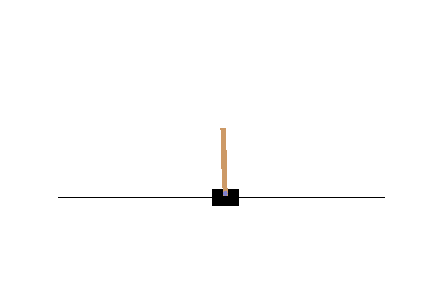
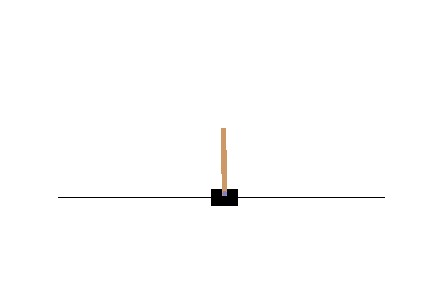
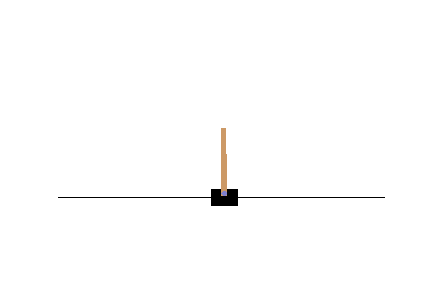
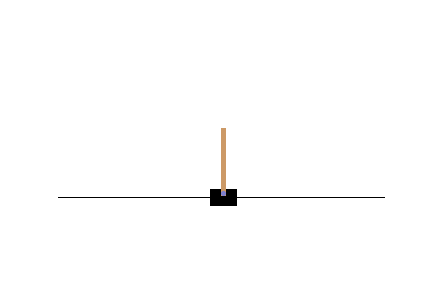
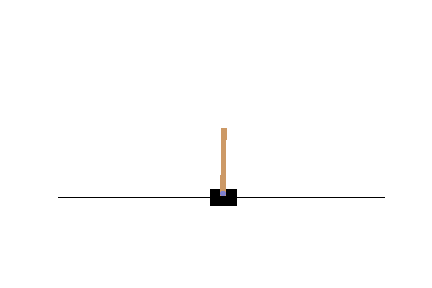
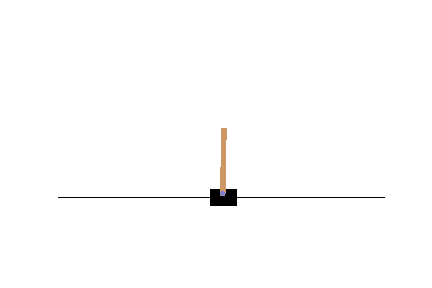
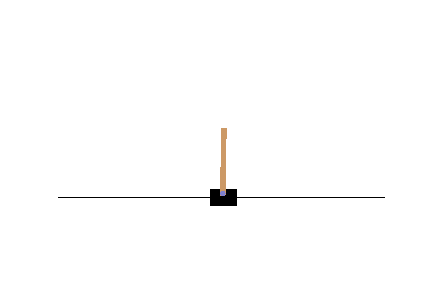
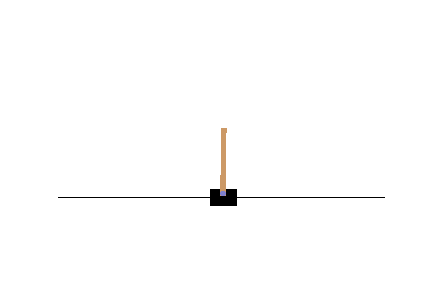
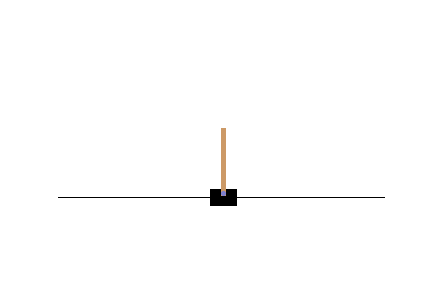
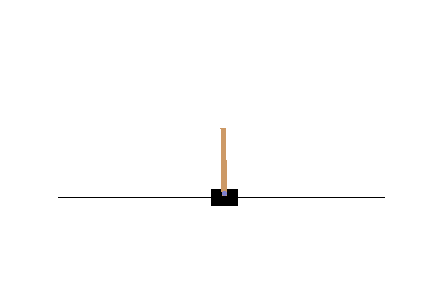
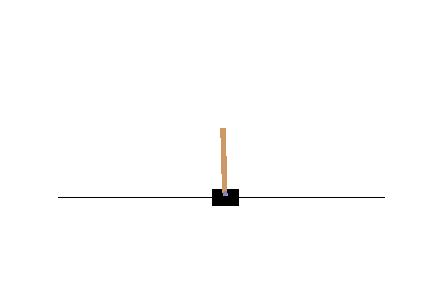
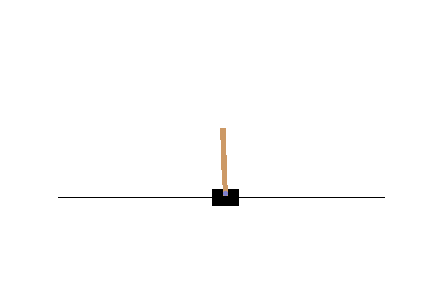
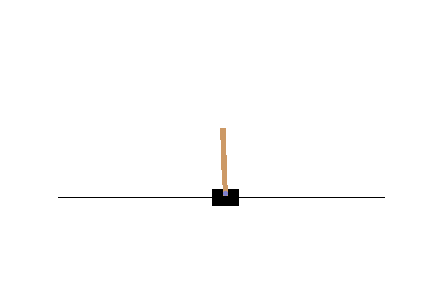
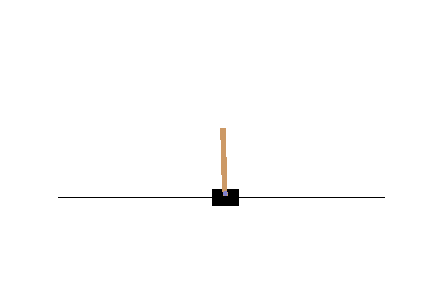
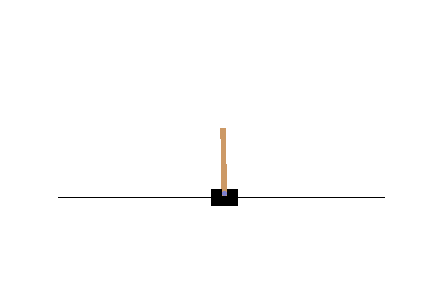
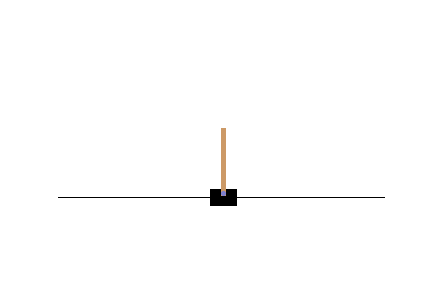
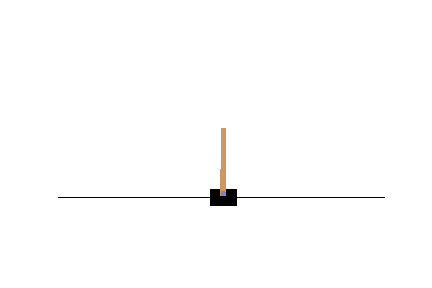
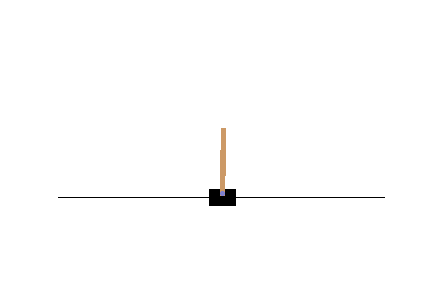
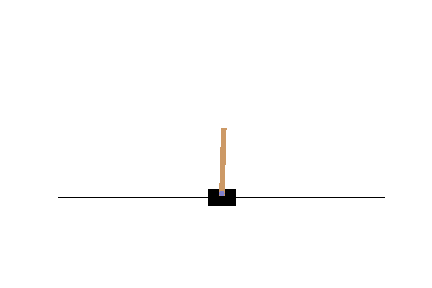
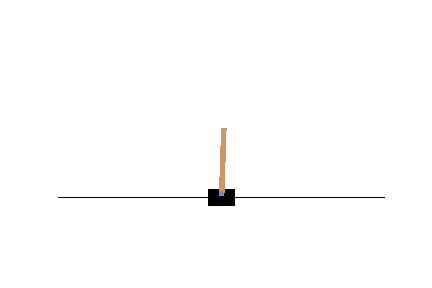
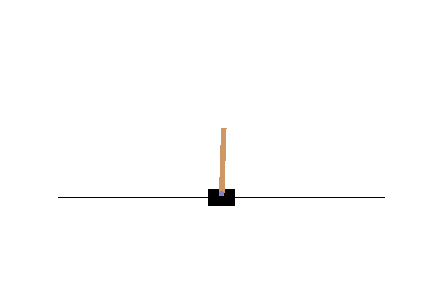
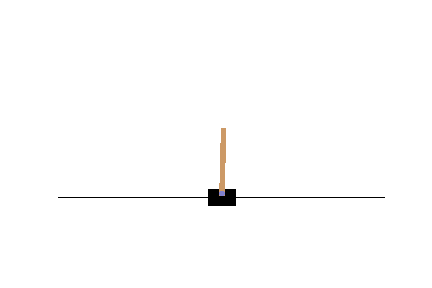
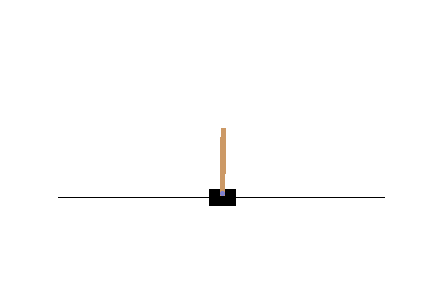
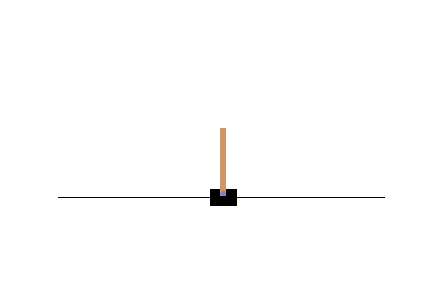
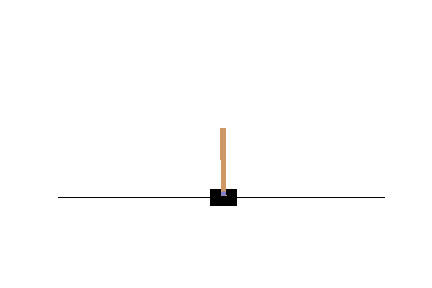
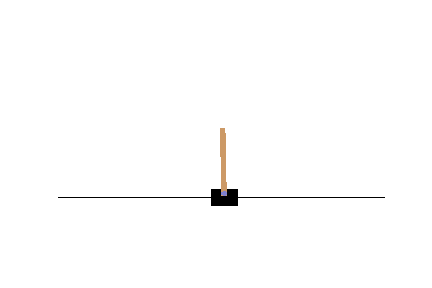
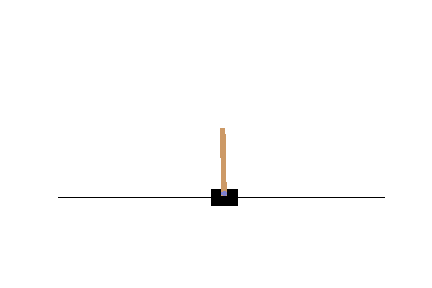
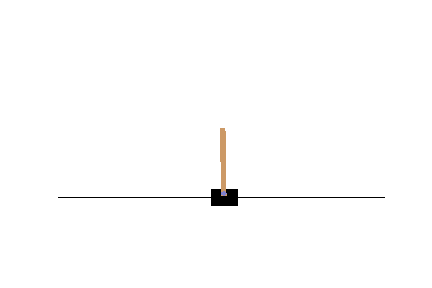
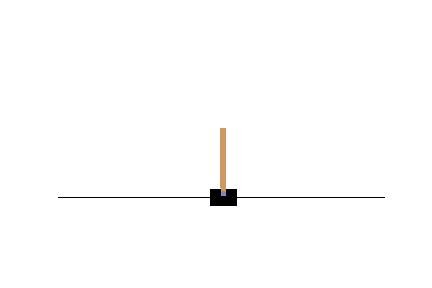
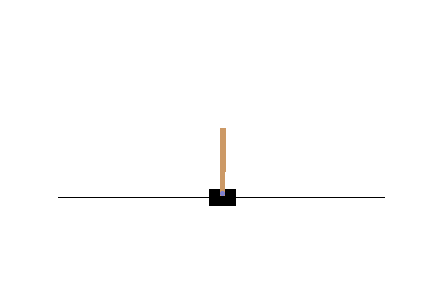
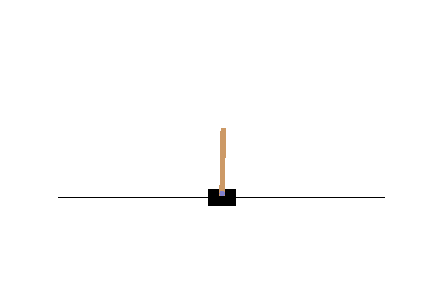
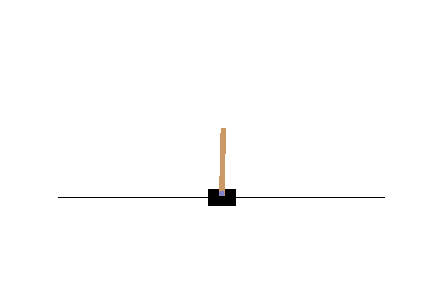
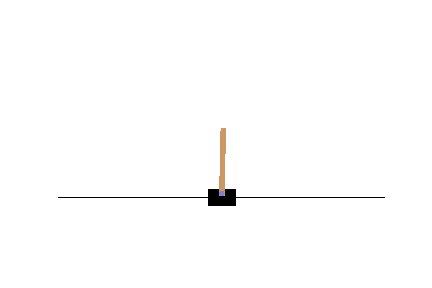
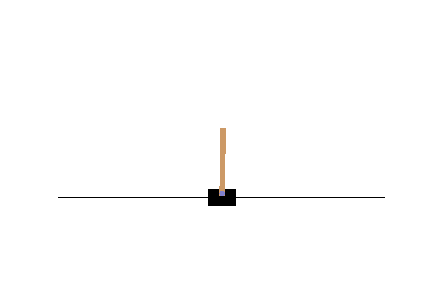
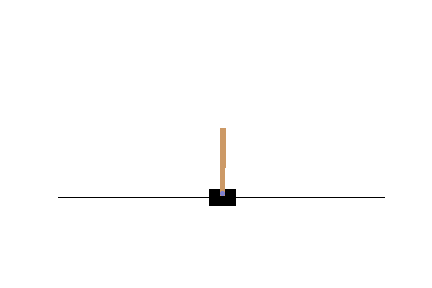
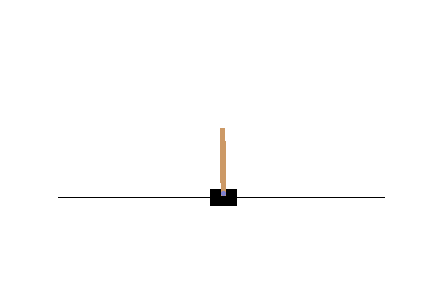
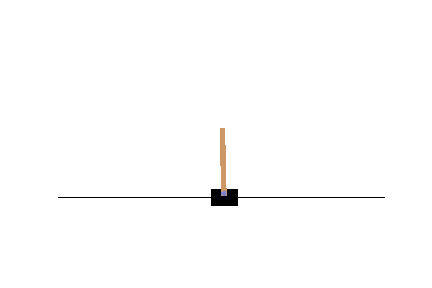
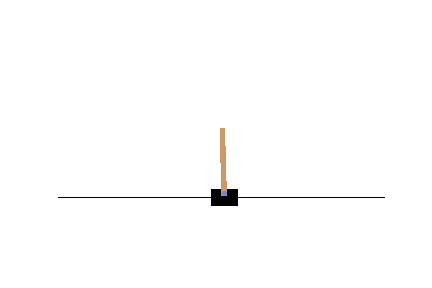
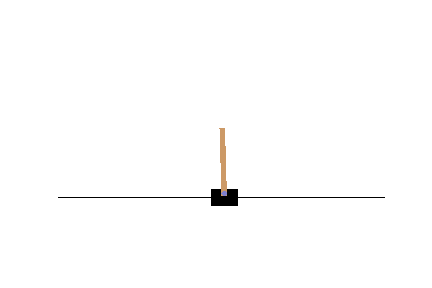
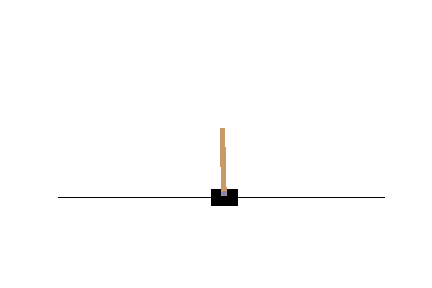
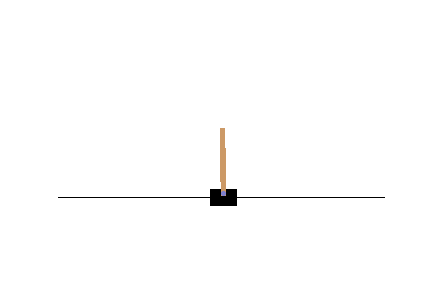
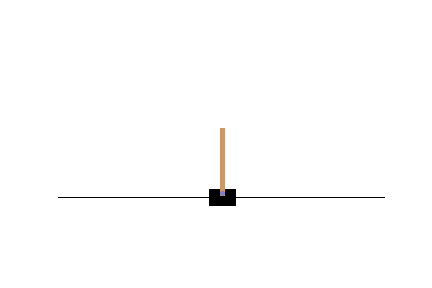
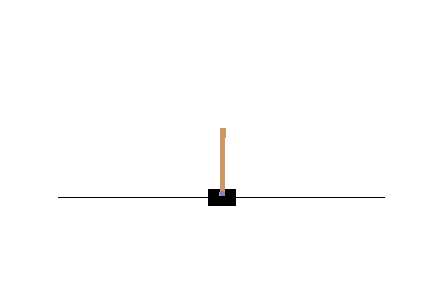
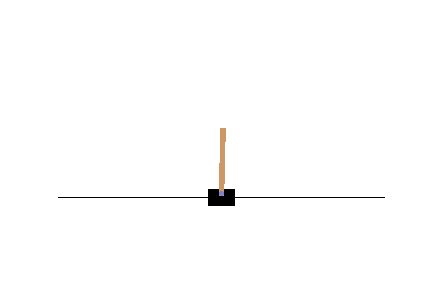
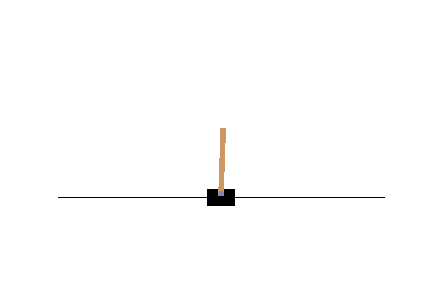
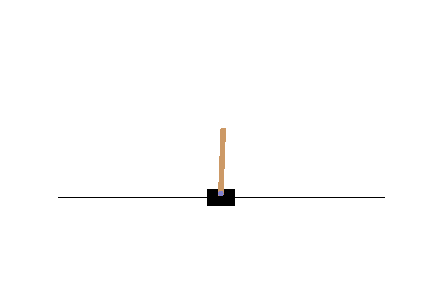
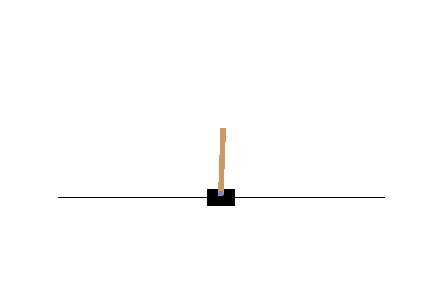
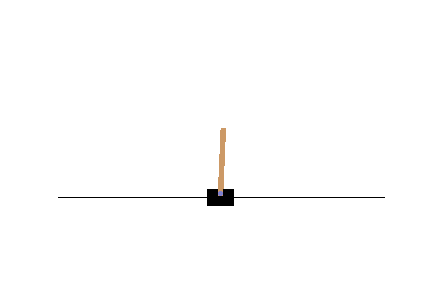
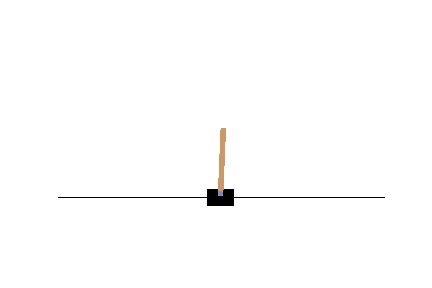
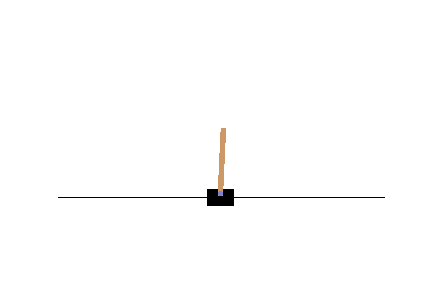
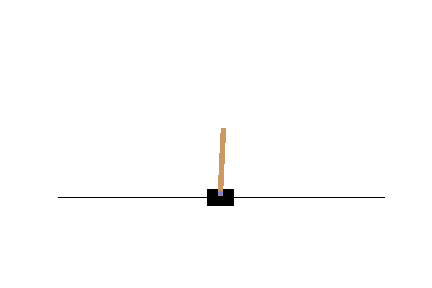
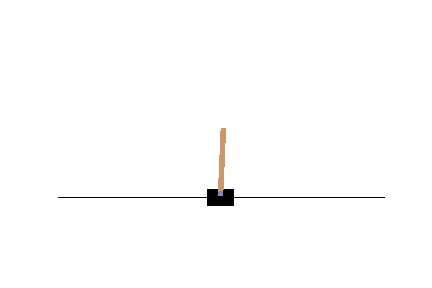
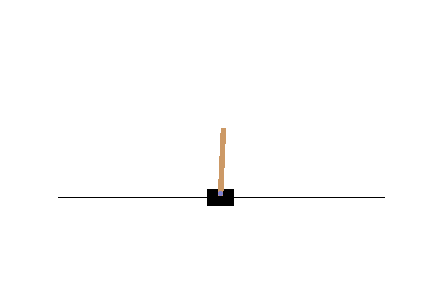
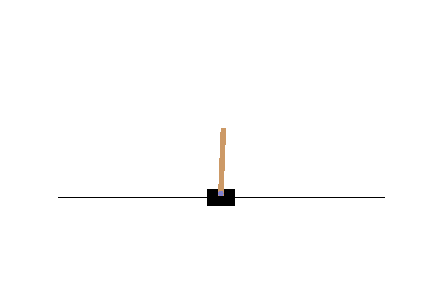
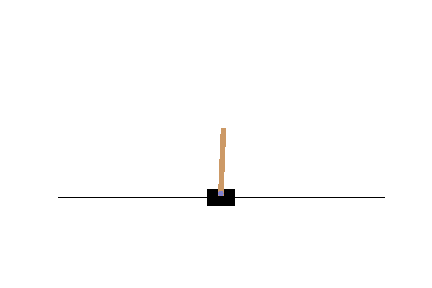
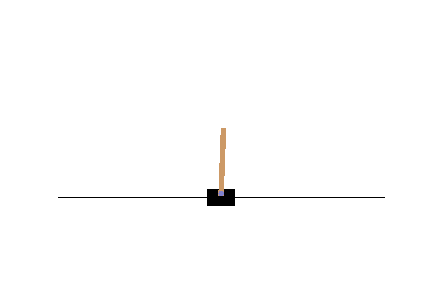
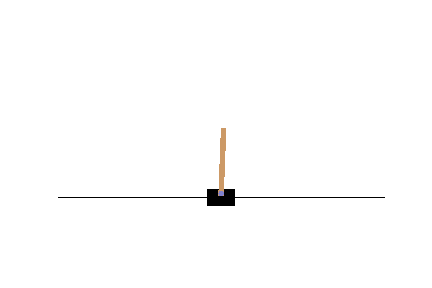
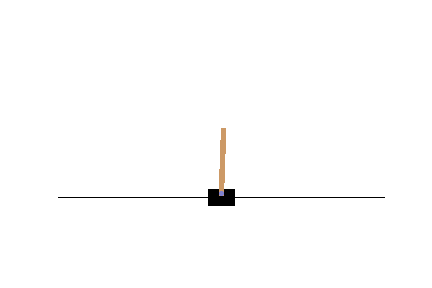
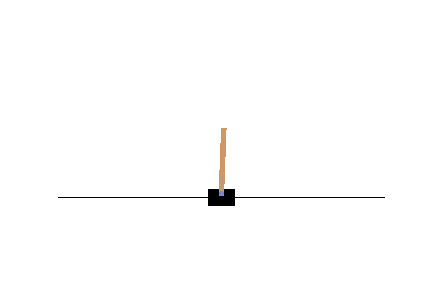
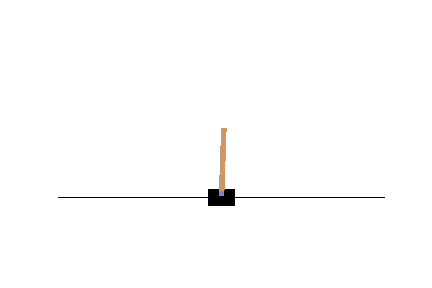
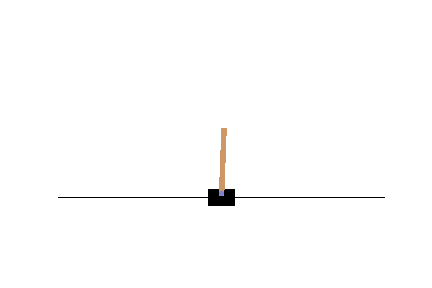
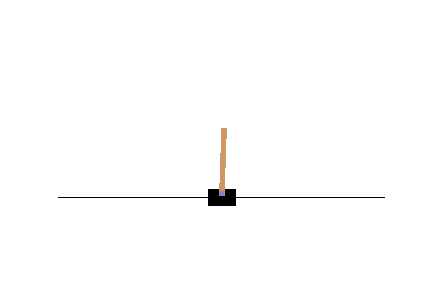
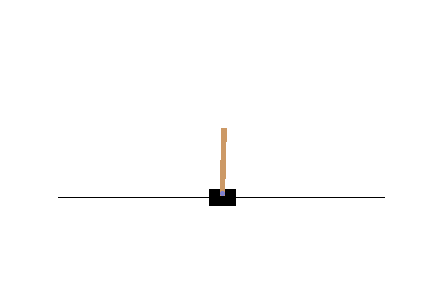
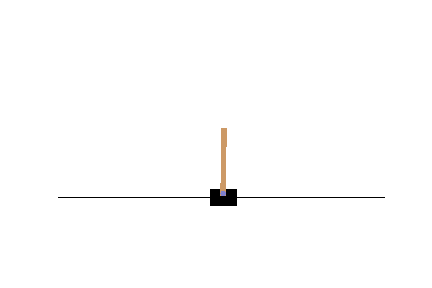
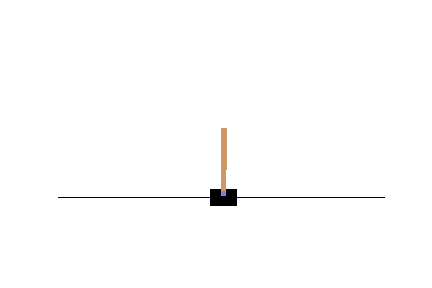
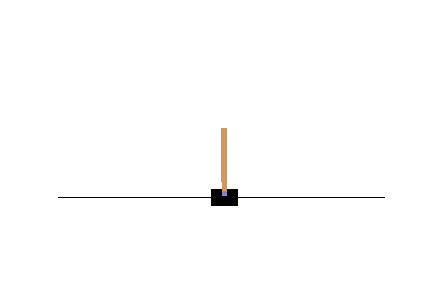
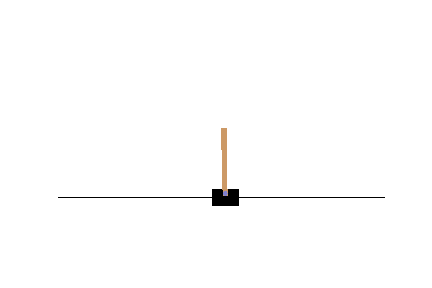
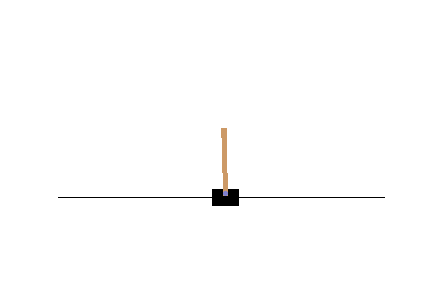
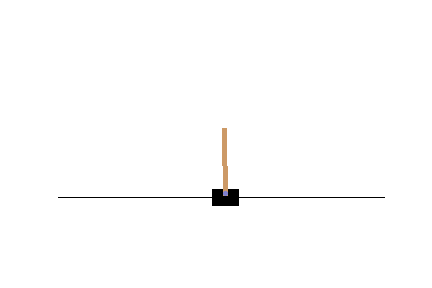
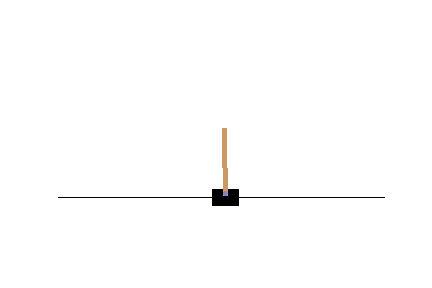
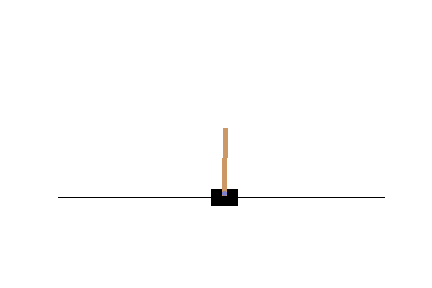
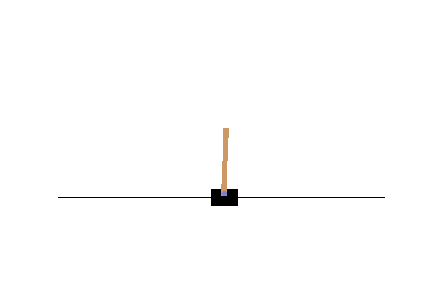
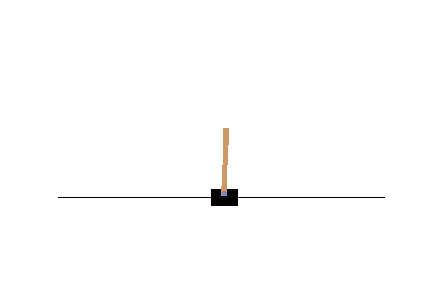
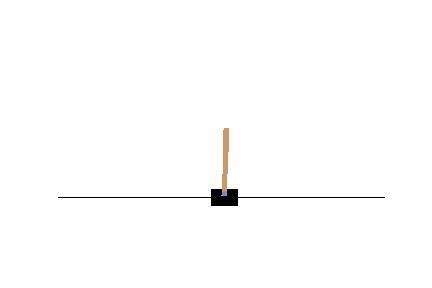
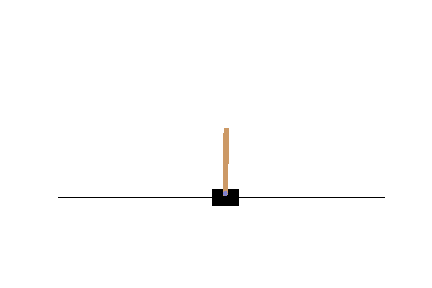
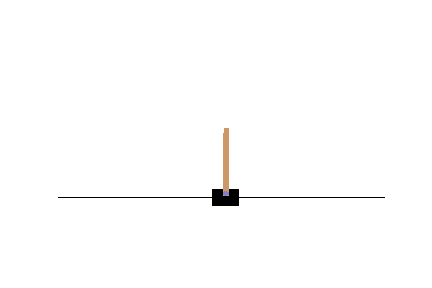
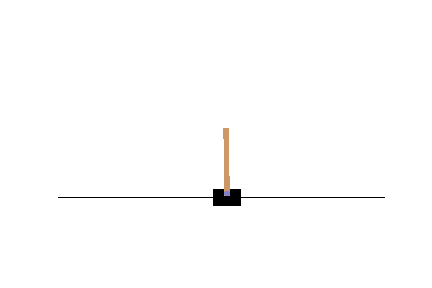
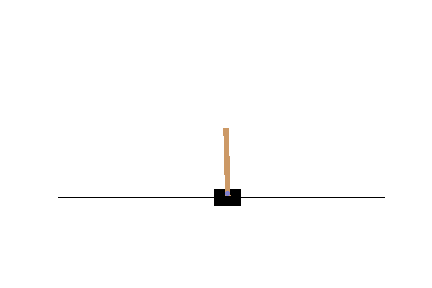
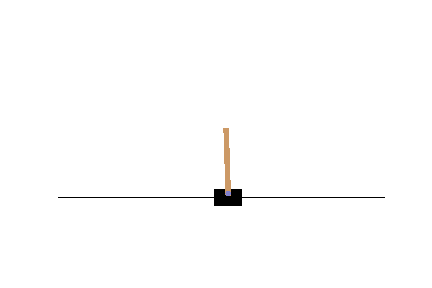
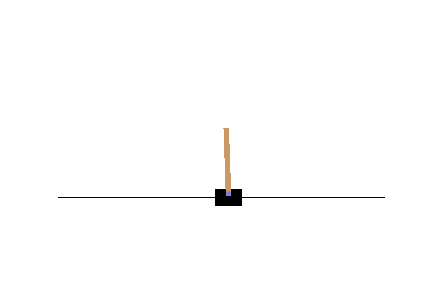
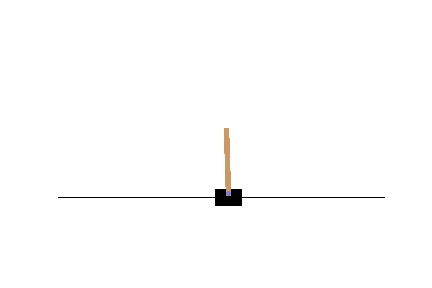
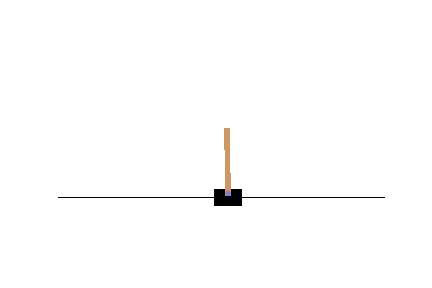
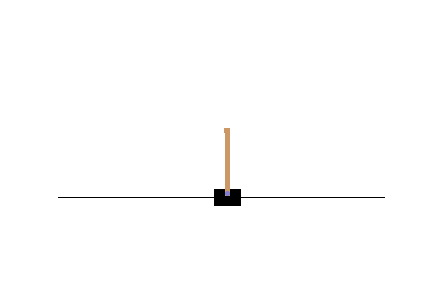
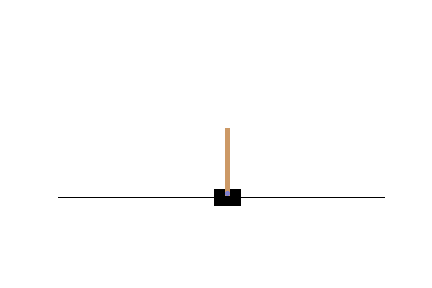
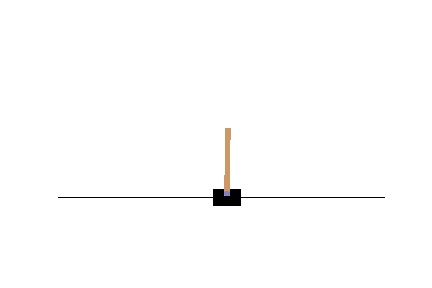
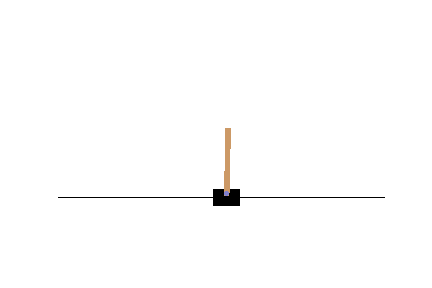
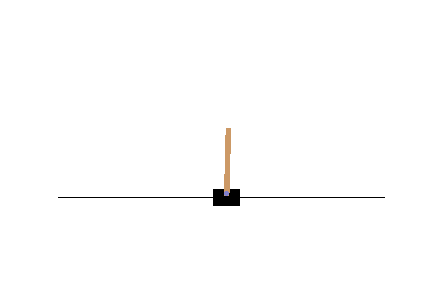
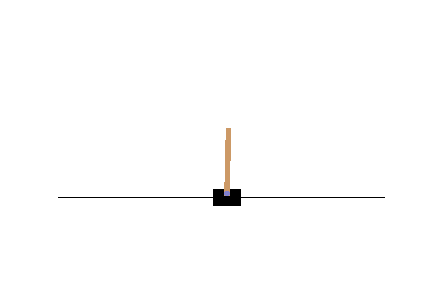
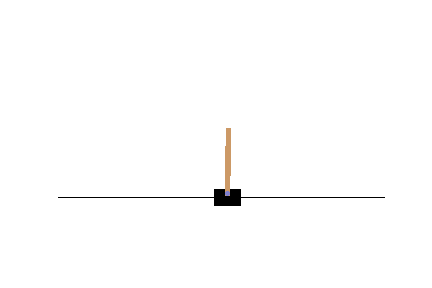
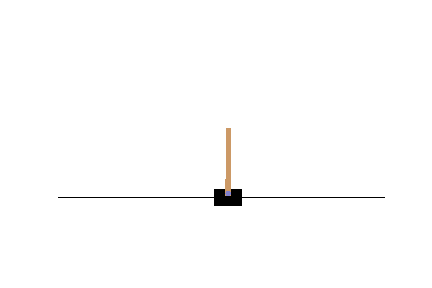
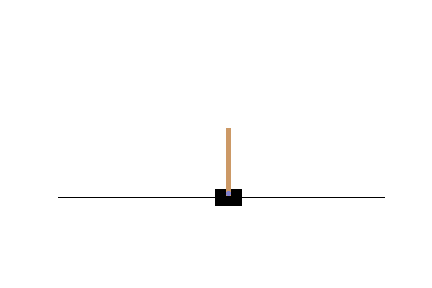
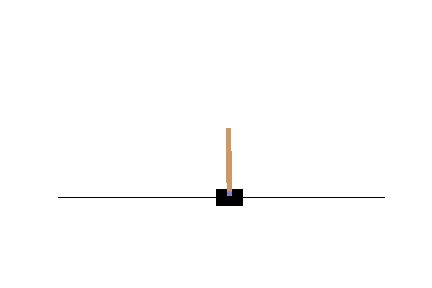
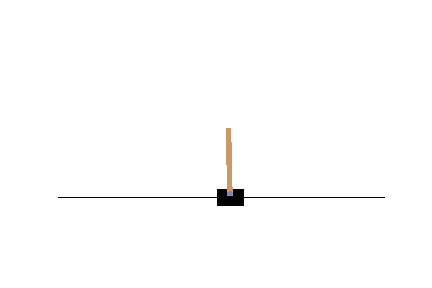
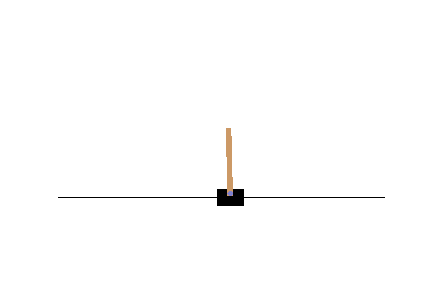
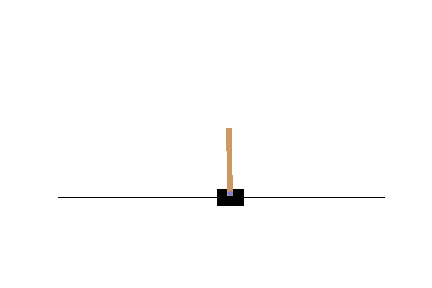
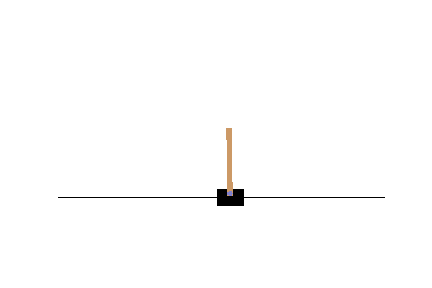
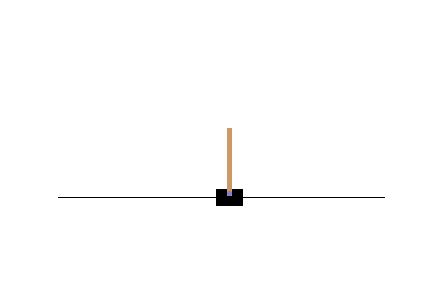
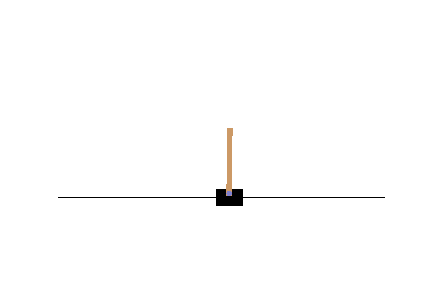
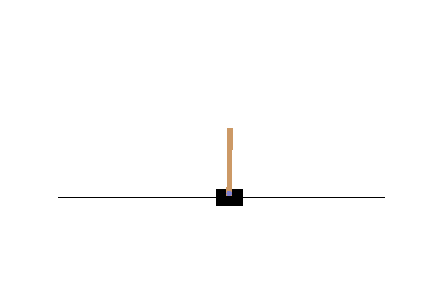
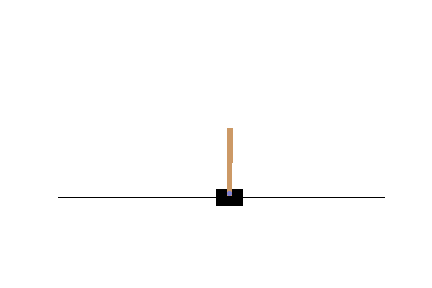
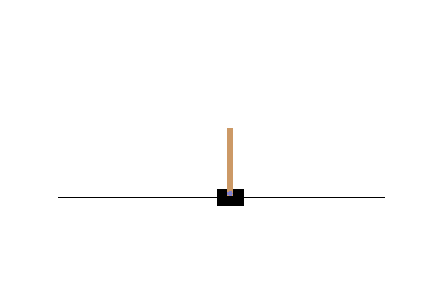
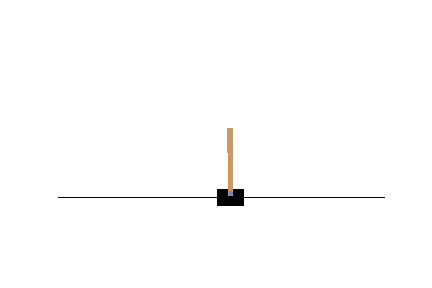
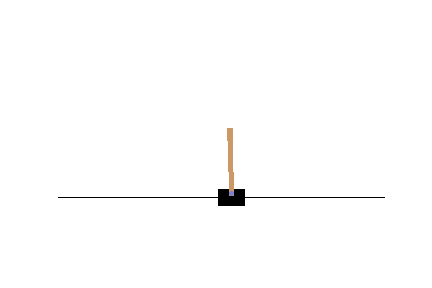
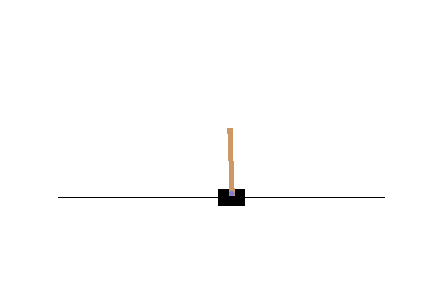
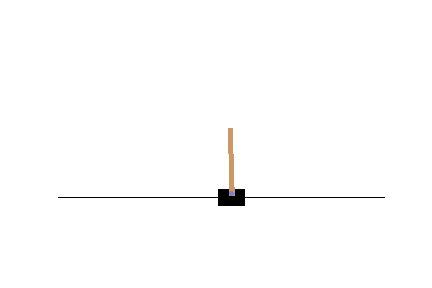
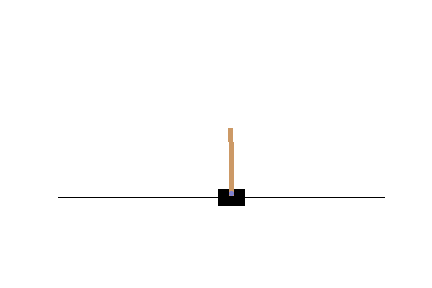
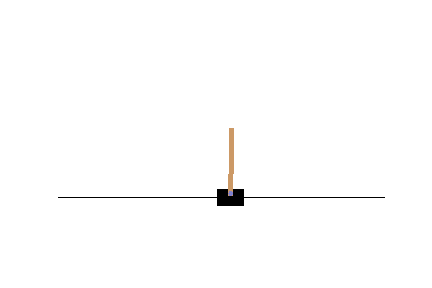
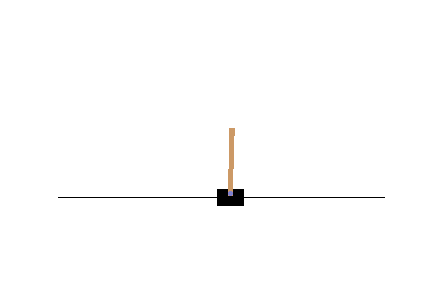
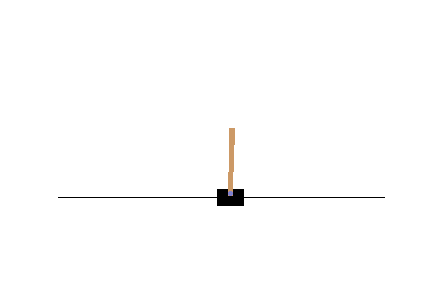
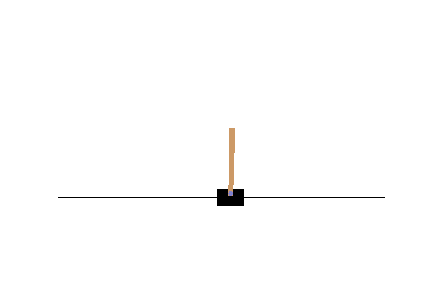
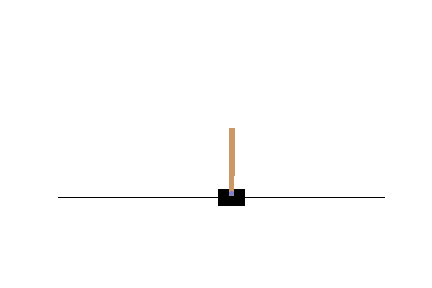
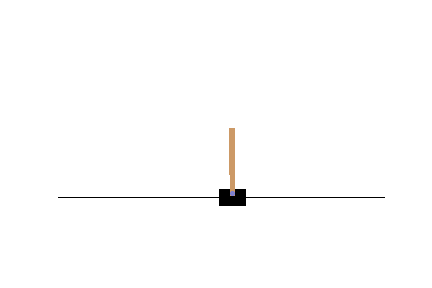
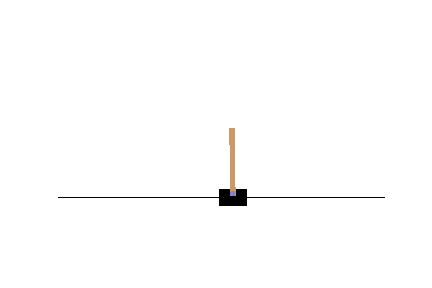
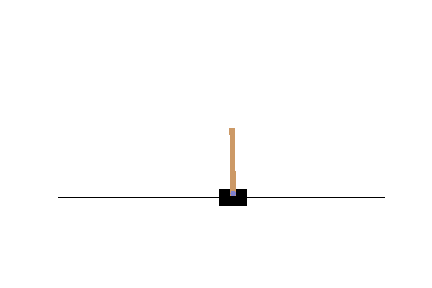
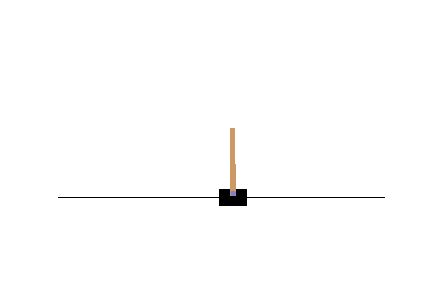
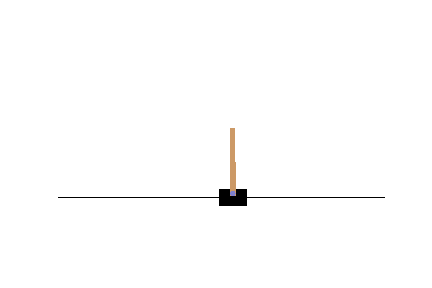
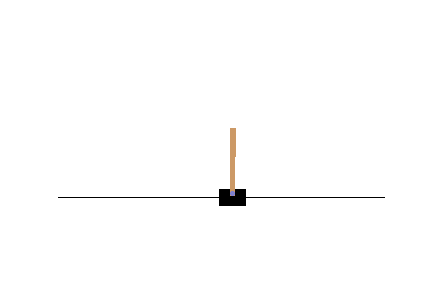
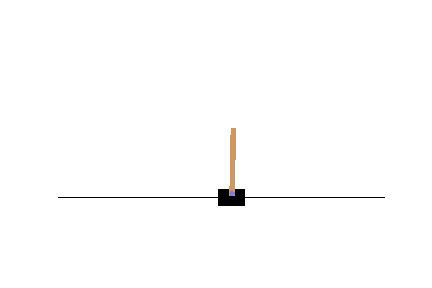
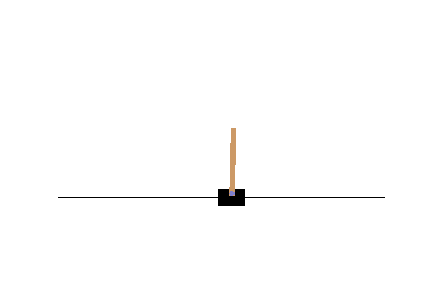
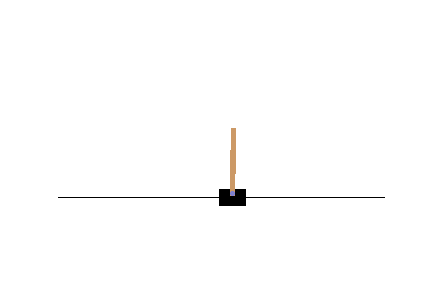
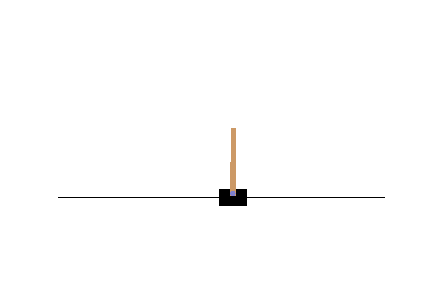
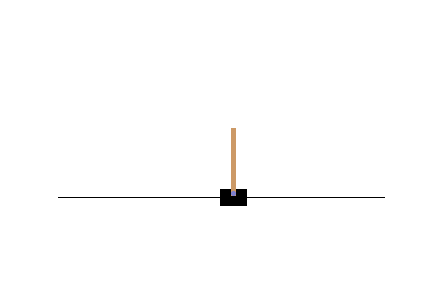
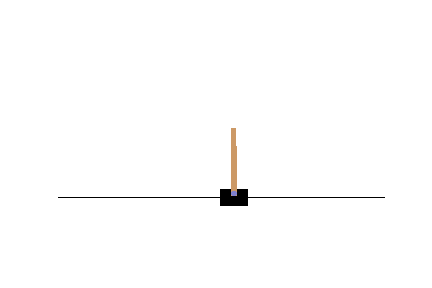
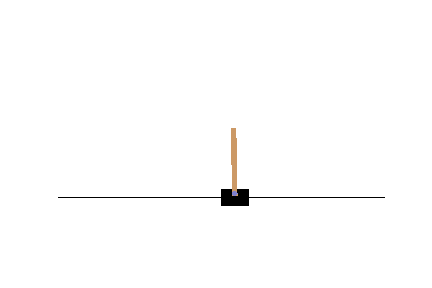
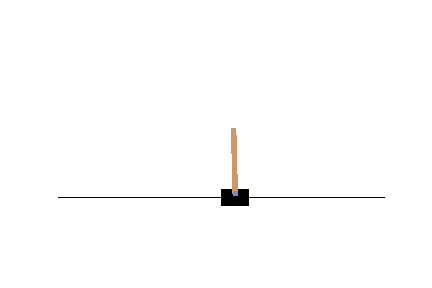
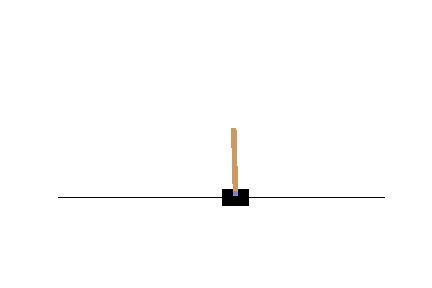
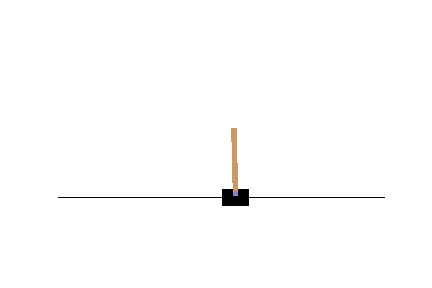
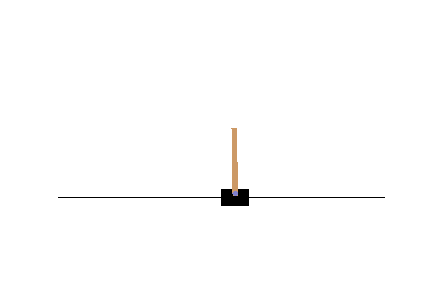
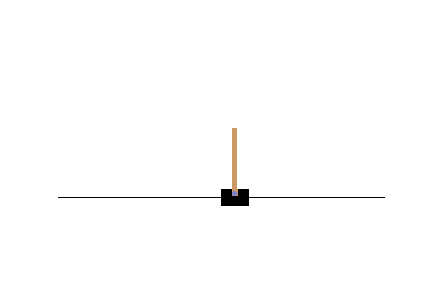
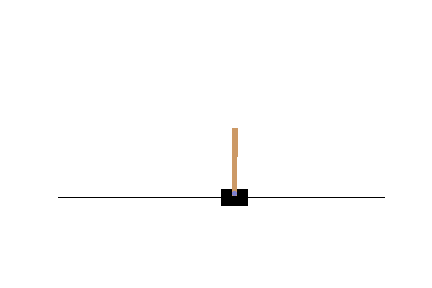
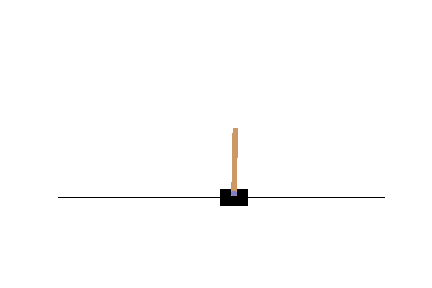
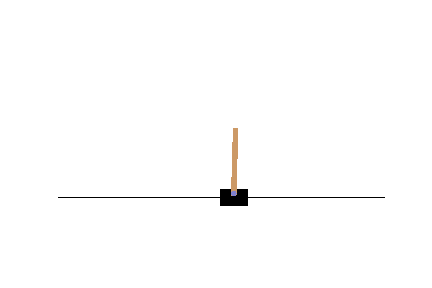
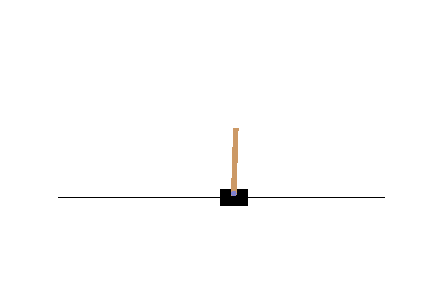
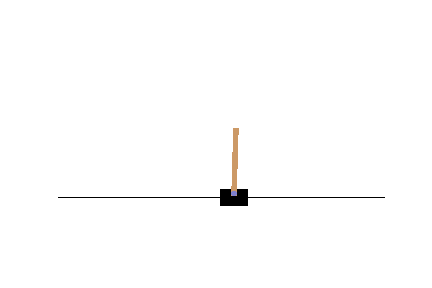
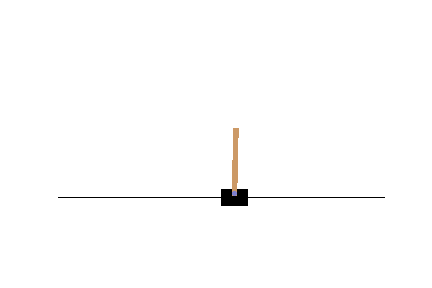
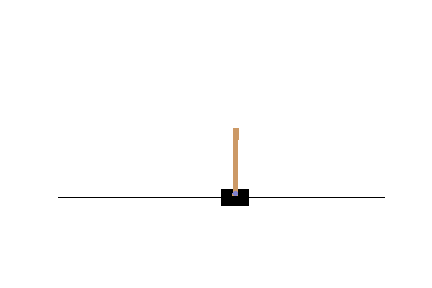
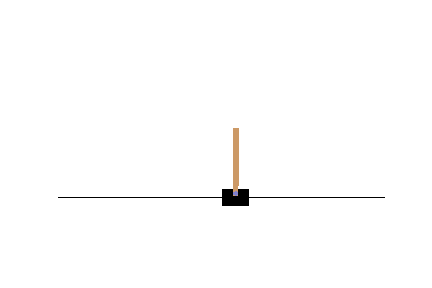
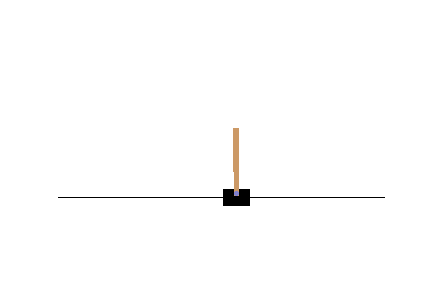
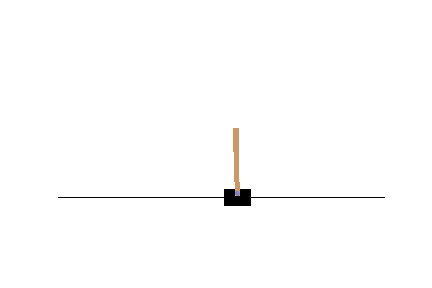
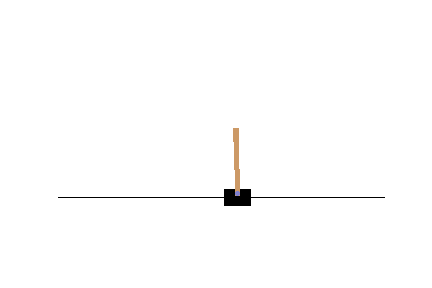
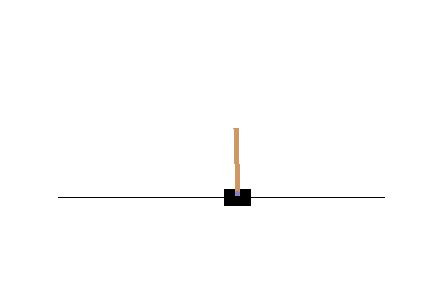
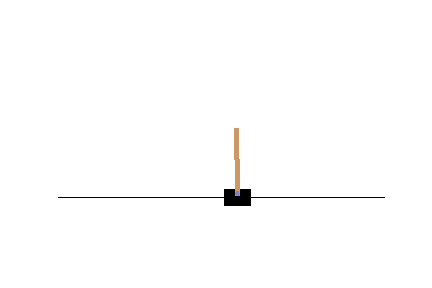
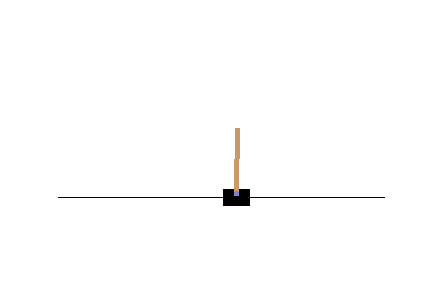
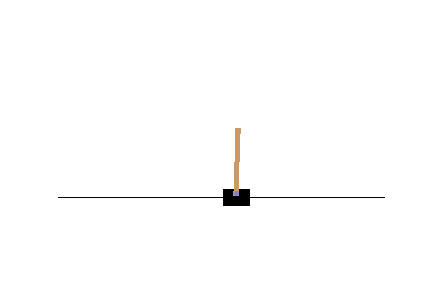
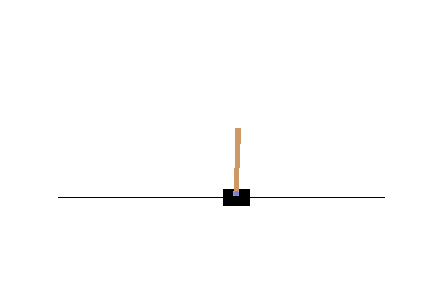
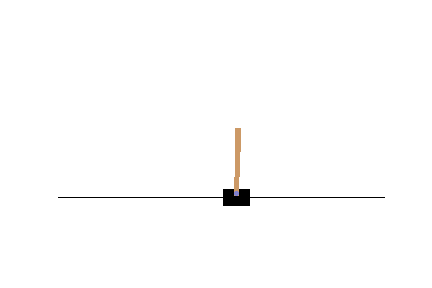
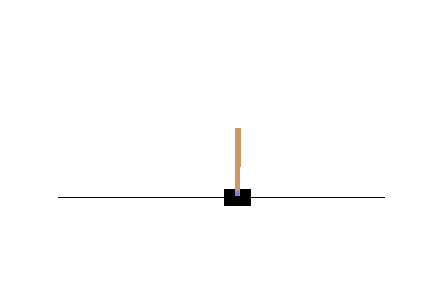
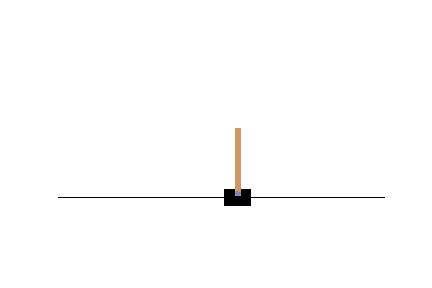
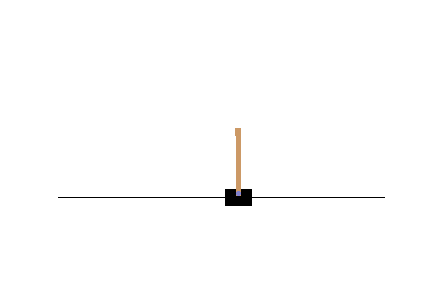
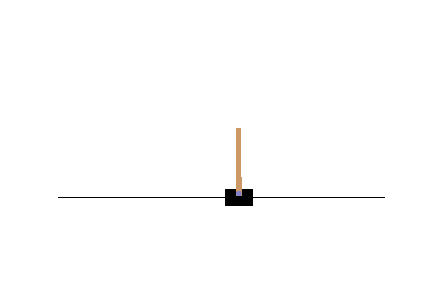
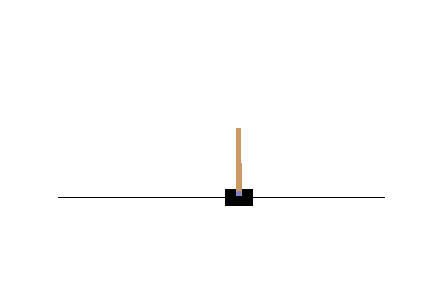
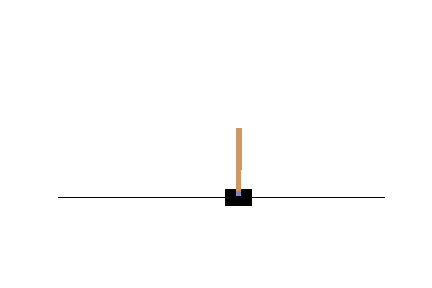
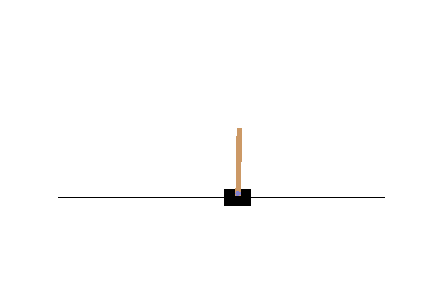
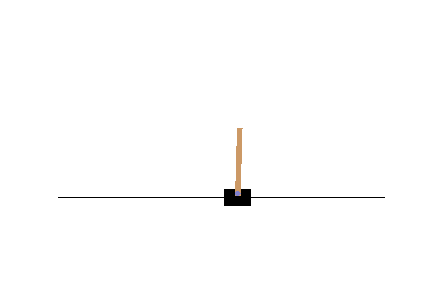
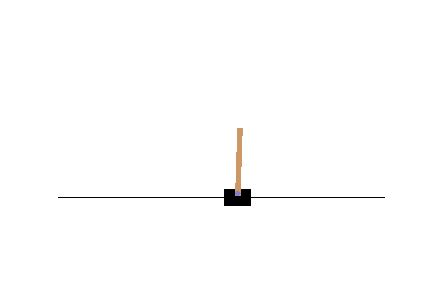
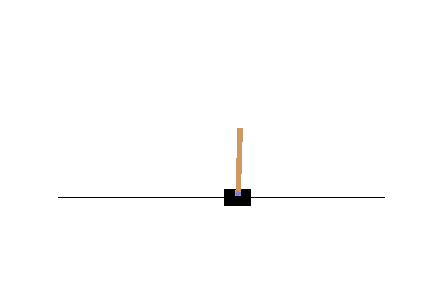
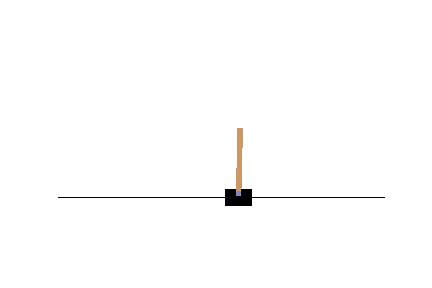
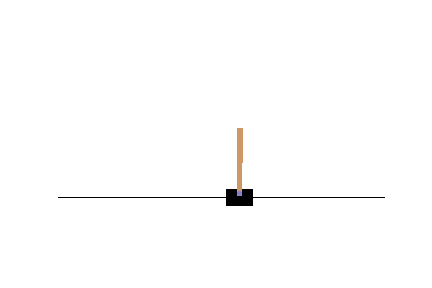
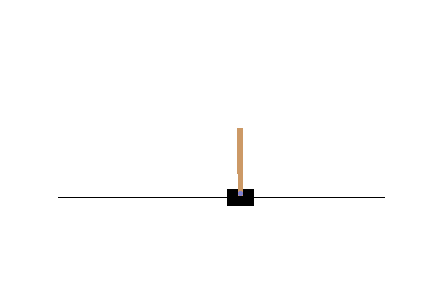
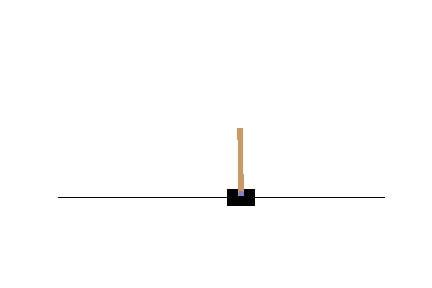
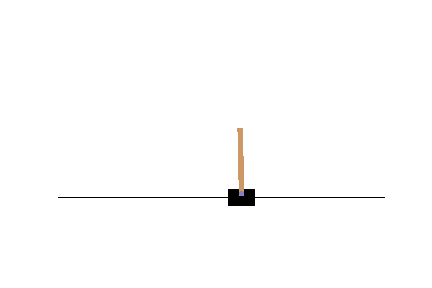
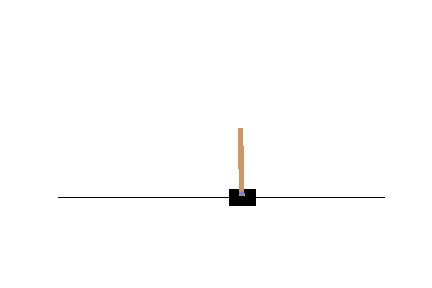
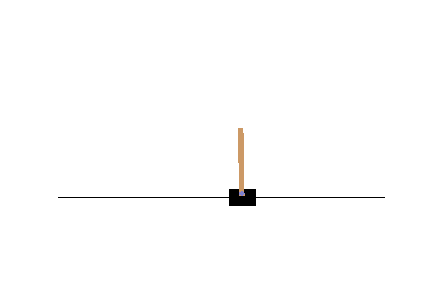
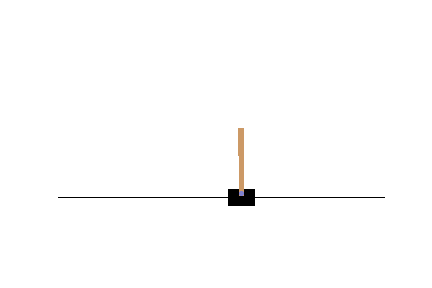
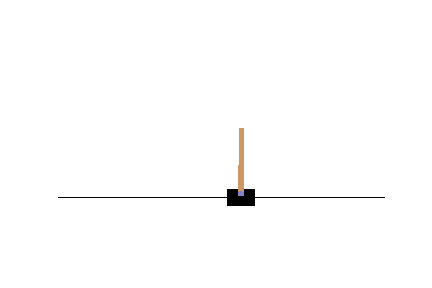
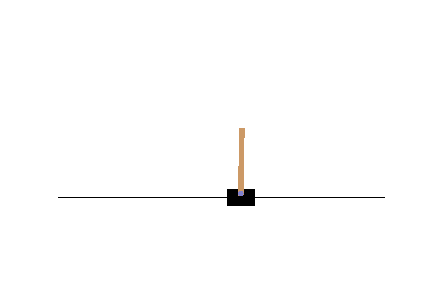
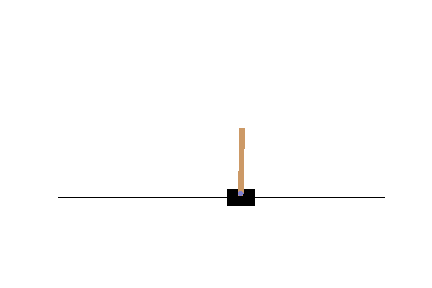
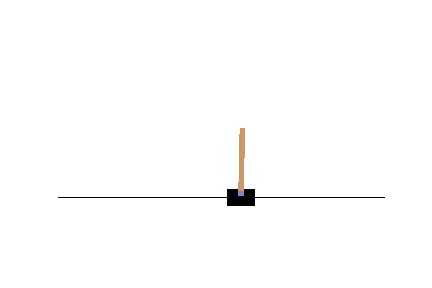

In [6]:
observation = env.reset()

frames = []
for _ in range(num_max_step):
    state = learn.digitize_state(observation, observation_low, observation_hight, num_dizitized)
    action = learning.get_action(state, episode)
    observation, reward, done, info =  env.step(action)
    frames.append(env.render(mode = 'rgb_array'))
    if done:
        break
        
disp.display_frames_as_gif(frames)

### 学習曲線

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


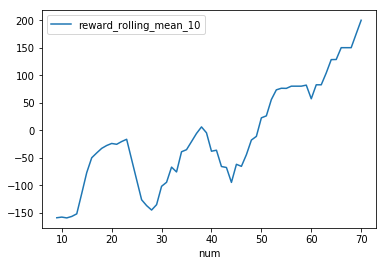

In [12]:
 # エピソード毎の獲得報酬を移動平均線で表示
df_rewards = pd.DataFrame({'num': range(0, len(rewards)), 'reward': rewards})
df_rewards['reward_rolling_mean_10'] = df_rewards['reward'].rolling(window=10,center=False).mean()
df_rewards.plot(kind='line', x='num', y=['reward_rolling_mean_10'])